In [39]:

import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob

import pandas as pd
import json

import os
import shutil
from random import randint
import seaborn as sns

from utils import generate_train_val_test_split, find_contours, generate_mask
%matplotlib inline



In [2]:
df = pd.read_json("./df_eda.json")

C:\Users\atkovacs\AppData\Local\Temp\ipykernel_28768\1692262075.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df = pd.read_json("./df_eda.json")


In [3]:
seed = randint(0, 100)
print(f"seed: {seed}")
df_split = generate_train_val_test_split(df=df, seed=seed)

seed: 92
len train 162
len val 54
len test 54


c:\Users\atkovacs\Documents\rail_detection_preparation\utils.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["set"] = "train"
c:\Users\atkovacs\Documents\rail_detection_preparation\utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["set"] = "val"
c:\Users\atkovacs\Documents\rail_detection_preparation\utils.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [4]:
df["sensor"].unique()

array(['ir_center', 'rgb_center', 'rgb_highres_center', 'ir_right',
       'rgb_right', 'rgb_highres_right', 'rgb_left', 'rgb_highres_left',
       'ir_left'], dtype=object)

In [5]:
###### FILTER TEST SETS #############
df_split = df_split[df_split["sensor"].str.contains("highres")]

In [6]:
df_split[["path", "set"]].drop_duplicates()["set"].value_counts()

set
train    200
val       66
test      64
Name: count, dtype: int64

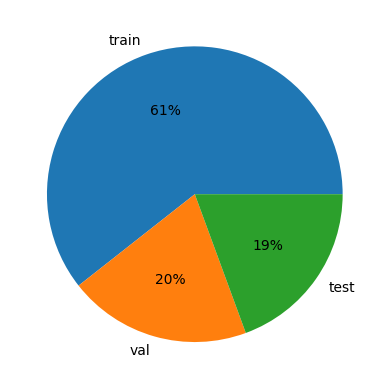

In [7]:
labels = df_split[["path", "set"]].drop_duplicates()["set"].value_counts().index
values = df_split[["path", "set"]].drop_duplicates()["set"].value_counts().values
_ = plt.pie(values, labels=labels, autopct="%.0f%%")

## How to generate segments

In [8]:
df_test = df_split[df_split["path"] == df_split["path"].values[0]]

In [9]:
df_test["path"].iloc[0]

'14_signals_station_14.1/rgb_highres_center/091_1631449460.200000005.png'

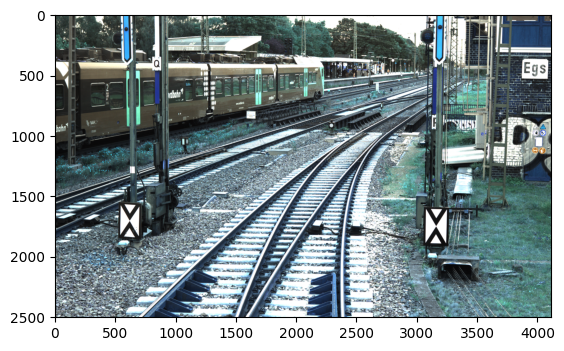

In [10]:
img = cv2.imread(f"./orig_data/DB/{df_test['path'].iloc[0]}")
plt.imshow(img)

In [11]:
thickness = int(img.shape[1] / 200)

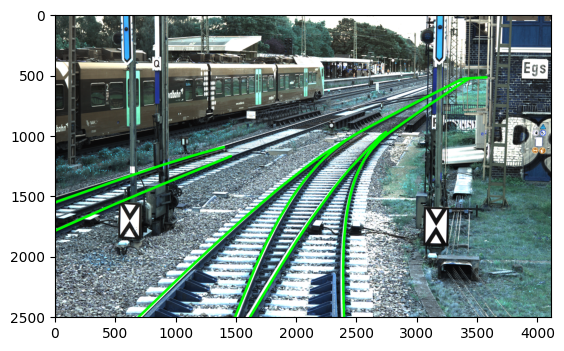

In [12]:
img_temp = img.copy()
for idx, row in df_test.iterrows():
    cv2.polylines(
        img_temp,
        np.int32([row["poly2d"]]),
        isClosed=row["closed"],
        color=(0, 255, 0),
        thickness=thickness,
    )
plt.imshow(img_temp)

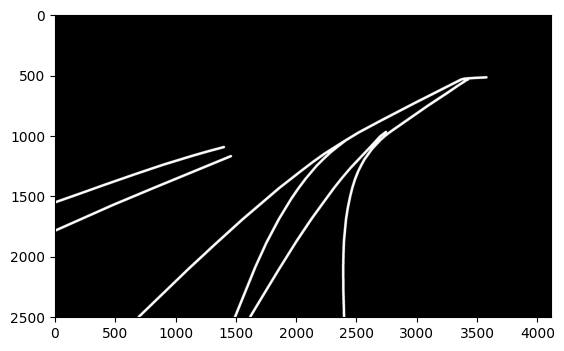

In [13]:
mask = np.zeros_like(img)
for idx, row in df_test.iterrows():
    cv2.polylines(
        mask,
        np.int32([row["poly2d"]]),
        isClosed=False,
        color=(255, 255, 255),
        thickness=thickness,
    )
plt.imshow(mask)

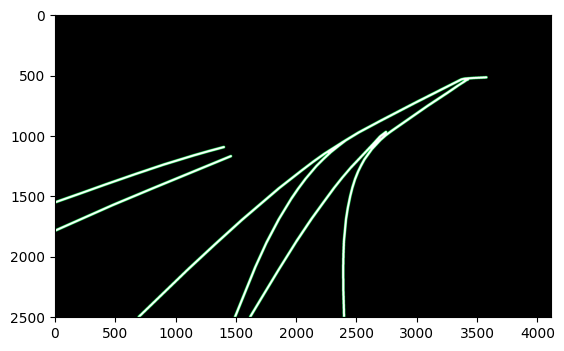

In [14]:
mask_temp = mask.copy()
imgray = cv2.cvtColor(mask_temp, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 0.5, 1, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(
    thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
cv2.drawContours(mask_temp, contours, -1, (0, 255, 75), 2)
plt.imshow(mask_temp)

In [15]:
len(contours)

3

In [16]:
for c in contours:
    print(len(c))

2479
1846
8135


In [17]:
contours_small = []
for idx, contour in enumerate(contours):
    contour = np.append(contour, [contour[0]], axis=0)
    con_short = cv2.approxPolyDP(contour, epsilon=0.8, closed=True)
    points = [p for point in con_short for p in point[0]]
    points += [points[0], points[1]]
    contours_small.append(points)

In [18]:
for c in contours_small:
    print(len(c))

278
288
656


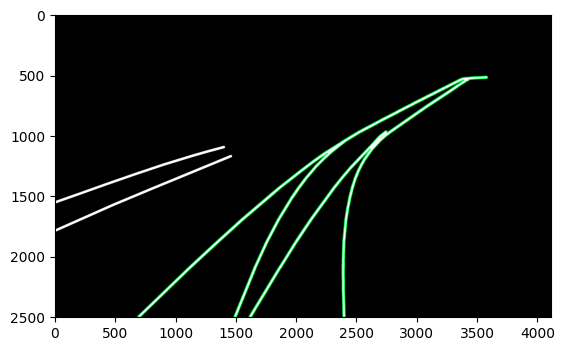

In [19]:
mask_temp = mask.copy()
cv2.drawContours(mask_temp, [con_short], -1, (0, 255, 75), 5)
plt.imshow(mask_temp)

## Foramlize ideas

In [20]:
df_test["path"].iloc[0]

'14_signals_station_14.1/rgb_highres_center/091_1631449460.200000005.png'

In [21]:
mask = generate_mask(df, df_test["path"].iloc[0])

In [22]:
lables, coordinates = find_contours(mask)

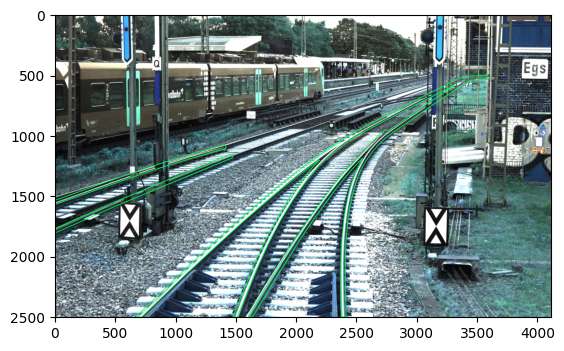

In [23]:
img_temp = img.copy()
for c in coordinates:
    cv2.drawContours(img_temp, [np.array(c)], -1, (0, 255, 75), 5)
plt.imshow(img_temp)

## Generate folder structure

In [30]:
path_raw = "../rail_detection/datasets/"
path_data = "data_highres"

In [31]:
yaml_content = f"""
path: ./{path_data}
train: train/images
val: val/images

nc: 1
names: ['track']
    """
with open(f"{path_raw}{path_data}.yml", "w") as f:
    f.write(yaml_content)

In [34]:
if not os.path.exists(path_raw):
    os.makedirs(path_raw)

if not os.path.exists(f"{path_raw}{path_data}"):
    os.makedirs(f"{path_raw}{path_data}")

if not os.path.exists(f"{path_raw}{path_data}/train"):
    os.makedirs(f"{path_raw}{path_data}/train")

if not os.path.exists(f"{path_raw}{path_data}/train/labels"):
    os.makedirs(f"{path_raw}{path_data}/train/labels")

if not os.path.exists(f"{path_raw}{path_data}/train/images"):
    os.makedirs(f"{path_raw}{path_data}/train/images")

if not os.path.exists(f"{path_raw}{path_data}/val"):
    os.makedirs(f"{path_raw}{path_data}/val")

if not os.path.exists(f"{path_raw}{path_data}/val/images"):
    os.makedirs(f"{path_raw}{path_data}/val/images")

if not os.path.exists(f"{path_raw}{path_data}/val/labels"):
    os.makedirs(f"{path_raw}{path_data}/val/labels")

if not os.path.exists(f"{path_raw}{path_data}/test"):
    os.makedirs(f"{path_raw}{path_data}/test")

if not os.path.exists(f"{path_raw}{path_data}/test/images"):
    os.makedirs(f"{path_raw}{path_data}/test/images")

if not os.path.exists(f"{path_raw}{path_data}/test/labels"):
    os.makedirs(f"{path_raw}{path_data}/test/labels")

In [35]:
for idx, row in df_split[["path", "set"]].drop_duplicates().iterrows():
    source = f"./orig_data/DB/{row['path']}"
    filename = row["path"].replace("/", "_")
    destination = f"{path_raw}{path_data}/{row['set']}/images/{filename}"
    shutil.copy(source, destination)

    mask = generate_mask(df, row["path"])
    labels, coordinates = find_contours(mask)
    with open(
        f"{path_raw}{path_data}/{row['set']}/labels/{filename.replace('png','txt')}",
        "w",
    ) as f:
        f.write("\n".join(labels))

## Test labeling

In [44]:
image = glob(f"{path_raw}{path_data}/train/images/*")[0]
label = image.replace("png", "txt").replace("image", "label")

In [45]:
with open(label, "r") as f:
    labels = f.read().splitlines()

In [46]:
img = cv2.imread(image)
h, w = img.shape[:2]
h

2504

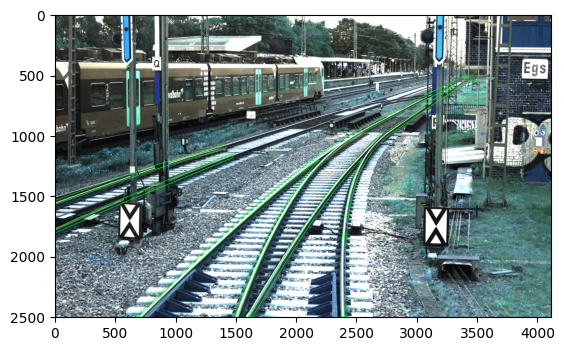

In [48]:
for label in labels:
    class_id, *poly = label.split(" ")

    poly = np.asarray(poly, dtype=np.float16).reshape(-1, 2)  # Read poly, reshape
    poly *= [w, h]  # Unscale

    cv2.polylines(img, [poly.astype("int")], True, (0, 255, 0), 4)  # Draw Poly Lines
    # cv2.fillPoly(img, [poly.astype('int')], (randint(0,255),randint(0,255),randint(0,255)), cv2.LINE_AA) # Draw area

    plt.imshow(img)